In [ ]:
import keras 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.datasets import imdb
import torch.optim as optim
from sklearn import metrics

# Loading dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3)
vocab = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

# dividing to train and test set
x_train, x_validation, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state= 42)

type(x_train)

1641221/1641221 [==============================] - 0s 0us/step


numpy.ndarray

In [ ]:
# batch size
batches = 50

In [ ]:
# convert x in the tensors
x_train = [torch.tensor(x) for x in x_train]
# create vectors with same size by adding zero
X_train = nn.utils.rnn.pad_sequence(x_train, batch_first=True, padding_value=0).long()
# divide training set into batches
X_train = X_train.view(-1, batches, X_train.shape[1])

In [ ]:
# convert x in the tensors
x_validation = [torch.tensor(x) for x in x_validation]
# create vectors with same size by adding zero
x_validation = nn.utils.rnn.pad_sequence(x_validation, batch_first=True, padding_value=0).long()
# divide training set into batches
x_validation = x_validation.view(-1, batches, x_validation.shape[1])

In [ ]:
# convert x in the tensors
x_test = [torch.tensor(x) for x in x_test]
# create vectors with same size by adding zero
X_test = nn.utils.rnn.pad_sequence(x_test, batch_first=True, padding_value=0,).long()
# divide training set into batches
X_test  = X_test.view(-1, batches, X_test.shape[1])

In [ ]:
y_train = torch.tensor(y_train).view(-1, batches)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [ ]:
# getting length to use as same length of train on test set and also validation set
vocabulary_length = int((X_train.max()+1).item())

In [ ]:
# create word embedding 
word_embed = nn.Embedding(vocabulary_length, 100)

In [ ]:
# https://towardsdatascience.com/convolutional-neural-network-in-natural-language-processing-96d67f91275c
# Build CNN model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.word_embed = nn.Embedding(vocabulary_length, 100)
        self.cnn = nn.Conv2d(1, 100, (3, 100))
        self.clf = nn.Linear(100, 2)

    def forward(self, x):
        # apply word embedding
        x = self.word_embed(x)
        # extra dimension for cnn
        x = x.unsqueeze(1)
        #  cnn
        x = self.cnn(x)
        # calculating maximum value of kernels - delete additional dimentions
        x = x.max(2)[0].squeeze(2)
        # applying ReLu function, get important features
        x = F.relu(x) 
        # linear nn for classification
        x = self.clf(x)
        # this will return probability of labels (like positive and negative)
        return F.softmax(x, 1)

In [ ]:
Cnn_model = Model()
optimizer = optim.Adam(Cnn_model.parameters(), lr=1e-3)
criterio  = nn.CrossEntropyLoss()

In [ ]:
def f1_score_cal(X_Test, y_real, Cnn_model):
  y_pred = []
  for x in X_Test:
      # get the higher probability
      y_pred.append(Cnn_model(x).argmax(1).cpu().detach())
  y_pred = torch.cat(y_pred)
  print("Accuracy is:", metrics.accuracy_score(y_true=y_real, y_pred=y_pred))
  return metrics.f1_score(y_true=y_real, y_pred=y_pred)

In [ ]:
# Training steps
epochs = 10
Loss_array = []
for e in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        
        # resetting the gradient from previous values
        optimizer.zero_grad()
        x, y = x, y
        # getting predication values
        y_pred = Cnn_model(x)
        # calculating loss values
        loss = criterio(y_pred, y)
        # calculating the gradient
        loss.backward()
        # calculating optimization (one step)
        optimizer.step()
        # appending all loss to loss array
        Loss_array.append(loss.item())
        if(i % 200 == 0):
            with torch.no_grad():
                f1 = f1_score_cal(x_validation, y_val, Cnn_model)
            print('Epoch:', e,'- Batch:', i, '- Loss:', torch.tensor(Loss_array[-100:]).mean(), ' - f1_score_val:', f1)

Accuracy is: 0.4874
Epoch: 0 - Batch: 0 - Loss: tensor(0.7442)  - f1_score_val: 0.0
Accuracy is: 0.7632
Epoch: 0 - Batch: 200 - Loss: tensor(0.5805)  - f1_score_val: 0.7544587308170883
Accuracy is: 0.8154
Epoch: 1 - Batch: 0 - Loss: tensor(0.5112)  - f1_score_val: 0.8292953578694285
Accuracy is: 0.8408
Epoch: 1 - Batch: 200 - Loss: tensor(0.4677)  - f1_score_val: 0.8444704962876123
Accuracy is: 0.85
Epoch: 2 - Batch: 0 - Loss: tensor(0.4408)  - f1_score_val: 0.8548199767711963
Accuracy is: 0.8596
Epoch: 2 - Batch: 200 - Loss: tensor(0.4136)  - f1_score_val: 0.8611001187178472
Accuracy is: 0.8602
Epoch: 3 - Batch: 0 - Loss: tensor(0.3959)  - f1_score_val: 0.8598355724884701
Accuracy is: 0.8656
Epoch: 3 - Batch: 200 - Loss: tensor(0.3771)  - f1_score_val: 0.8662952646239553
Accuracy is: 0.8602
Epoch: 4 - Batch: 0 - Loss: tensor(0.3683)  - f1_score_val: 0.8551295336787564
Accuracy is: 0.8548
Epoch: 4 - Batch: 200 - Loss: tensor(0.3569)  - f1_score_val: 0.8469645868465431
Accuracy is: 0.87

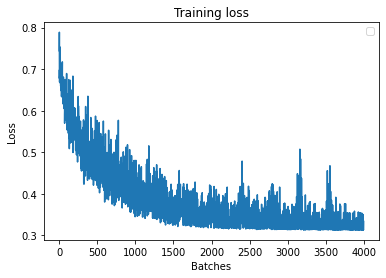

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.plot(Loss_array)
plt.show()

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in Cnn_model.state_dict():
    print(param_tensor, "\t", Cnn_model.state_dict()[param_tensor].size())

Model's state_dict:
word_embed.weight 	 torch.Size([88587, 100])
cnn.weight 	 torch.Size([100, 1, 3, 100])
cnn.bias 	 torch.Size([100])
clf.weight 	 torch.Size([2, 100])
clf.bias 	 torch.Size([2])


In [ ]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
from google.colab import drive
# Mount google drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SLU Semesters/SLU 3rd Semester/NLP/Final Project/models/
%ls

Mounted at /content/drive
/content/drive/MyDrive/SLU Semesters/SLU 3rd Semester/NLP/Final Project/models
model_1_epoch.pt  model.pt


In [ ]:
# torch.save(Cnn_model,'/content/drive/MyDrive/SLU Semesters/SLU 3rd Semester/NLP/Final Project/models/model_10_epoch.pt')

In [ ]:
# loaded_model = torch.load('/content/drive/MyDrive/SLU Semesters/SLU 3rd Semester/NLP/Final Project/models/model.pt')
# loaded_model.eval()

In [ ]:
print("F1_test:",f1_score_cal(X_test, y_test, loaded_model))